In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.max_columns', None)

In [2]:
market_open = pd.Timestamp("09:30:00").time()
market_close = pd.Timestamp("16:00:00").time()

In [3]:
import ta

def add_technical_indicators(df):
    """
    Compute technical indicators for a given DataFrame with OHLC-like structure.
    """
    # Make a copy of the DataFrame to avoid modifying the original
    df = df.copy()

    ### TREND INDICATORS ###
    df["ADX_5"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_last"], window=5
    ).adx()
    df["ADX_7"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_last"], window=7
    ).adx()
    df["ADX_10"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_last"], window=10
    ).adx()
    df["DMP_5"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_last"], window=5
    ).adx_pos()
    df["DMP_10"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_last"], window=10
    ).adx_pos()
    df["DMN_5"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_last"], window=5
    ).adx_neg()
    df["DMN_10"] = ta.trend.ADXIndicator(
        df["mid_price_high"], df["mid_price_low"], df["mid_price_last"], window=10
    ).adx_neg()

    # Aroon Indicator requires both high and low prices
    df["AROONU_7"] = ta.trend.AroonIndicator(
        df["mid_price_high"], df["mid_price_low"], window=7
    ).aroon_up()
    df["AROOND_7"] = ta.trend.AroonIndicator(
        df["mid_price_high"], df["mid_price_low"], window=7
    ).aroon_down()

    # Open-Low and Open-High calculations
    df["OLL3"] = df["mid_price_first"] - df["mid_price_low"].rolling(window=3).min()
    df["OLL5"] = df["mid_price_first"] - df["mid_price_low"].rolling(window=5).min()
    df["OLL10"] = df["mid_price_first"] - df["mid_price_low"].rolling(window=10).min()
    df["OLL15"] = df["mid_price_first"] - df["mid_price_low"].rolling(window=15).min()
    df["OHH3"] = df["mid_price_high"].rolling(window=3).max() - df["mid_price_first"]
    df["OHH5"] = df["mid_price_high"].rolling(window=5).max() - df["mid_price_first"]

    ### OSCILLATORS ###
    df["STOCHk_7_3_3"] = ta.momentum.StochasticOscillator(
        df["mid_price_high"],
        df["mid_price_low"],
        df["mid_price_last"],
        window=7,
        smooth_window=3,
    ).stoch()
    df["STOCHd_7_3_3"] = ta.momentum.StochasticOscillator(
        df["mid_price_high"],
        df["mid_price_low"],
        df["mid_price_last"],
        window=7,
        smooth_window=3,
    ).stoch_signal()

    # Avoid NaN Stochastic values
    df["STOCHk_7_3_3"] = df["STOCHk_7_3_3"].ffill()
    df["STOCHd_7_3_3"] = df["STOCHd_7_3_3"].ffill()

    df["MACD_8_21_5"] = ta.trend.MACD(
        df["mid_price_last"], window_slow=21, window_fast=8, window_sign=5
    ).macd_diff()
    df["RSI_7"] = ta.momentum.RSIIndicator(df["mid_price_last"], window=7).rsi()
    df["AO_5_10"] = ta.momentum.AwesomeOscillatorIndicator(
        df["mid_price_high"], df["mid_price_low"], window1=5, window2=10
    ).awesome_oscillator()

    ### MOVING AVERAGES ###
    df["EMA_15"] = ta.trend.EMAIndicator(
        df["mid_price_last"], window=15
    ).ema_indicator()
    df["HMA_10"] = ta.trend.WMAIndicator(
        df["mid_price_last"], window=10
    ).wma()  # HMA is not directly available in 'ta', using WMA as a placeholder
    df["KAMA_3_2_10"] = ta.momentum.KAMAIndicator(
        df["mid_price_last"], window=3, pow1=2, pow2=10
    ).kama()
    df["MA_10"] = ta.trend.SMAIndicator(df["mid_price_last"], window=10).sma_indicator()
    df["MA_20"] = ta.trend.SMAIndicator(df["mid_price_last"], window=20).sma_indicator()

    # Rolling CO (Last - First)
    for w in [3, 4, 5, 6]:
        df[f"rmCO({w})"] = (
            (df["mid_price_last"] - df["mid_price_first"]).rolling(window=w).mean()
        )

    ### VOLATILITY INDICATORS ###
    df["Bollinger_Upper"] = ta.volatility.BollingerBands(
        df["mid_price_last"], window=20, window_dev=2
    ).bollinger_hband()
    df["Bollinger_Lower"] = ta.volatility.BollingerBands(
        df["mid_price_last"], window=20, window_dev=2
    ).bollinger_lband()
    df["U_minus_L"] = df["Bollinger_Upper"] - df["Bollinger_Lower"]
    df["MA20dSTD"] = df["mid_price_last"].rolling(window=20).std()

    ### OTHER INDICATORS ###
    df["CO"] = df["mid_price_last"] - df["mid_price_first"]
    df["C1O1"] = df["CO"].shift(1)
    df["C2O2"] = df["CO"].shift(2)
    df["C3O3"] = df["CO"].shift(3)
    df["range"] = df["mid_price_high"] - df["mid_price_low"]
    df["OH1"] = df["mid_price_high"].shift(1) - df["mid_price_first"].shift(1)

    return df.dropna()

In [4]:
def add_time_features(combined_df):

    # Compute seconds since market open (9:30 AM)
    market_open_time = combined_df.index.normalize() + pd.Timedelta(hours=9, minutes=30)
    combined_df["time_since_open"] = (combined_df.index - market_open_time).dt.total_seconds()

    # Add binary features for Monday and Friday
    combined_df["is_monday"] = (combined_df.index.weekday == 0).astype(int)  # Monday = 0
    combined_df["is_friday"] = (combined_df.index.weekday == 4).astype(int)  # Friday = 4

    # Add market session feature (morning = 0, afternoon = 1)
    combined_df["market_session"] = (combined_df["time_since_open"] > 3.5 * 3600).astype(int)

    return combined_df

In [5]:
def compute_order_book_features(
    raw_data, resample_rate, mid_price_variation_class_threshold=0.0
):

    df = raw_data.copy()

    # Compute the mid-price as the average of best bid/ask prices
    df["mid_price"] = df[["ask_px_00", "bid_px_00"]].mean(axis=1)
    df["mid_price"] = df["mid_price"].fillna(df["ask_px_00"])
    df["mid_price"] = df["mid_price"].fillna(df["bid_px_00"])

    # Compute the bid-ask spread
    df["bid_ask_spread"] = df["ask_px_00"] - df["bid_px_00"]

    # Compute the mid-price as the average of best bid/ask prices
    df["weighted_mid_price"] = (
        df["ask_px_00"] * df["bid_sz_00"] + df["bid_px_00"] * df["ask_sz_00"]
    ) / (df["bid_sz_00"] + df["ask_sz_00"])
    df["weighted_mid_price"] = df["weighted_mid_price"].fillna(df["ask_px_00"])
    df["weighted_mid_price"] = df["weighted_mid_price"].fillna(df["bid_px_00"])

    # Precompute masks for filtering specific actions
    trade_mask = df["action"] == "T"
    add_mask = df["action"] == "A"
    cancel_mask = df["action"] == "C"
    bid_mask = df["side"] == "B"
    ask_mask = df["side"] == "A"

    # Aggregate resampled data using efficient functions
    order_book_data = df.resample(resample_rate).agg(
        {
            "mid_price": ["first", "last", "max", "min", "mean", "std"],
            "weighted_mid_price": ["first", "last", "mean"],
            "bid_ask_spread": ["last", "mean", "std"],
            "bid_px_00": ["last", "mean"],
            "ask_px_00": ["last", "mean"],
            "bid_sz_00": ["last", "mean", "std"],
            "ask_sz_00": ["last", "mean", "std"],
            "ask_px_01": "mean",
            "bid_px_01": "mean",
        }
    )

    # Rename columns for clarity
    order_book_data.columns = [
        "mid_price_first",  # mid price
        "mid_price_last",
        "mid_price_high",
        "mid_price_low",
        "mid_price_mean",
        "std_mid_price",
        "weighted_mid_price_first",  # weighted mid price
        "weighted_mid_price_last",
        "weighted_mid_price_mean",
        "last_spread",  # bid-ask spread
        "mean_spread",
        "std_spread",
        "last_best_bid_price",  # bid price
        "mean_best_bid_price",
        "last_best_ask_price",  # ask price
        "mean_best_ask_price",
        "last_best_bid_size",  # bid size
        "mean_best_bid_size",
        "std_best_bid_size",
        "last_best_ask_size",  # ask size
        "mean_best_ask_size",
        "std_best_ask_size",
        "mean_second_ask_price",  # mean second ask price
        "mean_second_bid_price",  # mean second bid price
    ]

    # When there are no orders for the duration of the sample period, fill with the last available value
    order_book_data[
        [
            "last_best_bid_size",
            "last_best_ask_size",
            "mean_best_bid_size",
            "mean_best_ask_size",
        ]
    ] = order_book_data[
        [
            "last_best_bid_size",
            "last_best_ask_size",
            "mean_best_bid_size",
            "mean_best_ask_size",
        ]
    ].ffill()
    order_book_data[
        [
            "last_best_bid_price",
            "last_best_ask_price",
            "mean_best_bid_size",
            "mean_best_ask_size",
        ]
    ] = order_book_data[
        [
            "last_best_bid_price",
            "last_best_ask_price",
            "mean_best_bid_size",
            "mean_best_ask_size",
        ]
    ].ffill()

    # POSSIBLE TARGETS
    order_book_data["mid_price_variation"] = (
        order_book_data["mid_price_last"] / order_book_data["mid_price_first"] - 1
    )
    # Classify mid-price variations
    order_book_data["mid_price_variation_class"] = order_book_data[
        "mid_price_variation_class"
    ] = (
        np.where(
            np.abs(order_book_data["mid_price_variation"])
            > mid_price_variation_class_threshold,
            np.sign(order_book_data["mid_price_variation"]),
            0,
        )
        + 1
    )
    order_book_data["mean_mid_price_variation"] = (
        order_book_data["mid_price_mean"] / order_book_data["mid_price_first"] - 1
    )
    # Classify mean mid-price variations
    order_book_data["mean_mid_price_variation_class"] = (
        order_book_data["mean_mid_price_variation"] > 0
    ).astype(int)

    order_book_data["weighted_mid_price_variation"] = (
        order_book_data["weighted_mid_price_last"]
        / order_book_data["weighted_mid_price_first"]
        - 1
    )
    # Classify weighted mid-price variations
    order_book_data["weighted_mid_price_variation_class"] = (
        order_book_data["weighted_mid_price_variation"] > 0
    ).astype(int)

    # Compute trade-related values
    trade_prices = (
        df.loc[trade_mask, "price"]
        .resample(resample_rate)
        .agg(["first", "last", "max", "min"])
    )
    trade_prices.columns = ["trade_open", "trade_close", "trade_high", "trade_low"]

    # Compute total bid/ask volume (additions - cancellations)
    order_book_data["total_bid_volume"] = df.loc[add_mask & bid_mask, "size"].astype(
        "int64"
    ).resample(resample_rate).sum().fillna(0) - df.loc[
        cancel_mask & bid_mask, "size"
    ].astype(
        "int64"
    ).resample(
        resample_rate
    ).sum().fillna(
        0
    )
    order_book_data["total_ask_volume"] = df.loc[add_mask & ask_mask, "size"].astype(
        "int64"
    ).resample(resample_rate).sum().fillna(0) - df.loc[
        cancel_mask & ask_mask, "size"
    ].astype(
        "int64"
    ).resample(
        resample_rate
    ).sum().fillna(
        0
    )

    # Compute order book imbalance metrics
    order_book_data["mean_order_book_imbalance"] = (
        order_book_data["mean_best_bid_size"].astype("int64")
        - order_book_data["mean_best_ask_size"].astype("int64")
    ) / (order_book_data["mean_best_bid_size"] + order_book_data["mean_best_ask_size"])

    order_book_data["last_order_book_imbalance"] = (
        order_book_data["last_best_bid_size"].astype("int64")
        - order_book_data["last_best_ask_size"].astype("int64")
    ) / (order_book_data["last_best_bid_size"] + order_book_data["last_best_ask_size"])

    order_book_data["total_net_order_flow"] = order_book_data[
        "last_best_bid_size"
    ].astype("int64") - order_book_data["last_best_ask_size"].astype("int64")

    # Count order actions
    order_book_data["num_added_orders"] = (
        df.loc[add_mask].resample(resample_rate).size()
    )
    order_book_data["num_canceled_orders"] = (
        df.loc[cancel_mask].resample(resample_rate).size()
    )
    order_book_data["num_traded_orders"] = (
        df.loc[trade_mask].resample(resample_rate).size()
    )

    # Compute rolling averages (5s window)
    order_book_data["order_book_imbalance_5s"] = (
        order_book_data["mean_order_book_imbalance"].rolling(5).mean()
    )

    order_book_data["order_flow_5s"] = (
        order_book_data["total_net_order_flow"].rolling(5).mean()
    )

    # Compute bid/ask price/volume variations
    order_book_data["bid_volume_variation"] = (
        order_book_data["last_best_bid_size"].astype("int64").diff()
    )
    order_book_data["ask_volume_variation"] = (
        order_book_data["last_best_ask_size"].astype("int64").diff()
    )
    order_book_data["bid_price_variation"] = (
        order_book_data["last_best_bid_price"].astype("int64").diff()
    )
    order_book_data["ask_price_variation"] = (
        order_book_data["last_best_ask_price"].astype("int64").diff()
    )

    # Merge trade data with resampled data
    order_book_data = order_book_data.merge(
        trade_prices, left_index=True, right_index=True, how="left"
    )

    # Drop NaNs after merging
    order_book_data.dropna(inplace=True)

    return order_book_data

In [18]:
AAPL_data_path = "AAPL_data/AAPL_2024-10-01_xnas-itch.parquet"

raw_data = pd.read_parquet(AAPL_data_path)

raw_data = raw_data.between_time(market_open, market_close)

order_book_data = compute_order_book_features(raw_data, "1s", mid_price_variation_class_threshold=0.0)
enriched_data = add_technical_indicators(order_book_data)

print(enriched_data.columns)
enriched_data.head()

Index(['mid_price_first', 'mid_price_last', 'mid_price_high', 'mid_price_low',
       'mid_price_mean', 'std_mid_price', 'weighted_mid_price_first',
       'weighted_mid_price_last', 'weighted_mid_price_mean', 'last_spread',
       'mean_spread', 'std_spread', 'last_best_bid_price',
       'mean_best_bid_price', 'last_best_ask_price', 'mean_best_ask_price',
       'last_best_bid_size', 'mean_best_bid_size', 'std_best_bid_size',
       'last_best_ask_size', 'mean_best_ask_size', 'std_best_ask_size',
       'mean_second_ask_price', 'mean_second_bid_price', 'mid_price_variation',
       'mid_price_variation_class', 'weighted_mid_price_variation',
       'weighted_mid_price_variation_class', 'total_bid_volume',
       'total_ask_volume', 'mean_order_book_imbalance',
       'last_order_book_imbalance', 'total_net_order_flow', 'num_added_orders',
       'num_canceled_orders', 'num_traded_orders', 'order_book_imbalance_5s',
       'order_flow_5s', 'bid_volume_variation', 'ask_volume_variation

,mid_price_first,mid_price_last,mid_price_high,mid_price_low,mid_price_mean,std_mid_price,weighted_mid_price_first,weighted_mid_price_last,weighted_mid_price_mean,last_spread,...,Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1
ts_recv,,,,,,,,,,,,,,,,,,,,,
2024-10-01 09:30:28-04:00,228.970,228.940,228.970,228.935,228.950376,0.013397,228.970000,228.954286,228.952646,0.04,...,229.034060,228.619940,0.414121,0.106220,-0.030,0.080,0.035,-0.095,0.035,0.110
2024-10-01 09:30:29-04:00,228.940,228.950,228.950,228.910,228.933392,0.010650,228.954286,228.944920,228.934991,0.04,...,229.014190,228.630810,0.383380,0.098335,0.010,-0.030,0.080,0.035,0.040,0.000
2024-10-01 09:30:30-04:00,228.950,228.955,228.955,228.885,228.924916,0.018742,228.944920,228.947130,228.926241,0.03,...,229.028085,228.627915,0.400170,0.102641,0.005,0.010,-0.030,0.080,0.070,0.010
2024-10-01 09:30:31-04:00,228.955,228.825,228.955,228.815,228.897054,0.046209,228.947130,228.811656,228.896598,0.05,...,229.022802,228.626698,0.396105,0.101599,-0.130,0.005,0.010,-0.030,0.140,0.005
2024-10-01 09:30:32-04:00,228.825,228.885,228.910,228.825,228.873875,0.027299,228.811656,228.895714,228.875182,0.03,...,229.028271,228.629229,0.399043,0.102352,0.060,-0.130,0.005,0.010,0.085,0.000


In [16]:
order_book_data["weighted_mid_price_variation_class"].value_counts()

weighted_mid_price_variation_class
0    9196
1    9051
Name: count, dtype: int64

In [ ]:
enriched_data["mid_price_variation_class"].value_counts()

mid_price_variation_class
 1.0    6150
-1.0    5845
 0.0    5713
Name: count, dtype: int64

# Feature selection

In [6]:
start_date = pd.to_datetime("2024-10-01")
end_date = pd.to_datetime("2024-10-02")
date_range = pd.bdate_range(start=start_date, end=end_date)
data_paths = [f"AAPL_data/AAPL_{date.strftime('%Y-%m-%d')}_xnas-itch.parquet" for date in date_range]

sampling_rate = '1s'

trade_days_data = []

for path in data_paths:
    raw_data = pd.read_parquet(path)
    raw_data = raw_data.reset_index().set_index("ts_event")

    raw_data = raw_data.between_time(market_open, market_close)
    
    order_book_data = compute_order_book_features(raw_data, sampling_rate)

    enriched_data = add_technical_indicators(order_book_data)    

    enriched_data.drop(columns=['mid_price_high', 'mid_price_low', 'mid_price_last', 'mid_price_first'], inplace=True)

    trade_days_data.append(enriched_data)

all_data = pd.concat(trade_days_data)

print(all_data.shape)
print(all_data.columns)

all_data.head()


(30596, 83)
Index(['mid_price_mean', 'std_mid_price', 'weighted_mid_price_first',
       'weighted_mid_price_last', 'weighted_mid_price_mean', 'last_spread',
       'mean_spread', 'std_spread', 'last_best_bid_price',
       'mean_best_bid_price', 'last_best_ask_price', 'mean_best_ask_price',
       'last_best_bid_size', 'mean_best_bid_size', 'std_best_bid_size',
       'last_best_ask_size', 'mean_best_ask_size', 'std_best_ask_size',
       'mean_second_ask_price', 'mean_second_bid_price', 'mid_price_variation',
       'mid_price_variation_class', 'mean_mid_price_variation',
       'mean_mid_price_variation_class', 'weighted_mid_price_variation',
       'weighted_mid_price_variation_class', 'total_bid_volume',
       'total_ask_volume', 'mean_order_book_imbalance',
       'last_order_book_imbalance', 'total_net_order_flow', 'num_added_orders',
       'num_canceled_orders', 'num_traded_orders', 'order_book_imbalance_5s',
       'order_flow_5s', 'bid_volume_variation', 'ask_volume_variati

,mid_price_mean,std_mid_price,weighted_mid_price_first,weighted_mid_price_last,weighted_mid_price_mean,last_spread,mean_spread,std_spread,last_best_bid_price,mean_best_bid_price,last_best_ask_price,mean_best_ask_price,last_best_bid_size,mean_best_bid_size,std_best_bid_size,last_best_ask_size,mean_best_ask_size,std_best_ask_size,mean_second_ask_price,mean_second_bid_price,mid_price_variation,mid_price_variation_class,mean_mid_price_variation,mean_mid_price_variation_class,weighted_mid_price_variation,weighted_mid_price_variation_class,total_bid_volume,total_ask_volume,mean_order_book_imbalance,last_order_book_imbalance,total_net_order_flow,num_added_orders,num_canceled_orders,num_traded_orders,order_book_imbalance_5s,order_flow_5s,bid_volume_variation,ask_volume_variation,bid_price_variation,ask_price_variation,trade_open,trade_close,trade_high,trade_low,ADX_5,ADX_7,ADX_10,DMP_5,DMP_10,DMN_5,DMN_10,AROONU_7,AROOND_7,OLL3,OLL5,OLL10,OLL15,OHH3,OHH5,STOCHk_7_3_3,STOCHd_7_3_3,MACD_8_21_5,RSI_7,AO_5_10,EMA_15,HMA_10,KAMA_3_2_10,MA_10,MA_20,rmCO(3),rmCO(4),rmCO(5),rmCO(6),Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1
ts_event,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-10-01 09:30:28-04:00,228.950376,0.013397,228.970000,228.954286,228.952646,0.04,0.040108,0.004776,228.92,228.930323,228.96,228.970430,150.0,96.559140,49.578542,25.0,123.924731,125.861919,228.980538,228.920323,-0.000131,0.0,-0.000086,0,-0.000069,0,82,550,-0.122458,0.714286,125,46,41,6,-0.220059,-69.4,100.0,-25.0,0.0,0.0,228.950,228.94,228.950,228.940,61.860430,44.504964,38.418590,25.517974,18.964730,3.556519,13.119081,85.714286,0.000000,0.115,0.165,0.31,0.315,0.03,0.030,70.731707,80.014017,0.017327,58.246974,0.05400,228.878176,228.898091,228.868471,228.8635,228.82700,0.028333,-0.00250,0.020,0.005000,229.034060,228.619940,0.414121,0.106220,-0.030,0.080,0.035,-0.095,0.035,0.110
2024-10-01 09:30:29-04:00,228.933392,0.010650,228.954286,228.944920,228.934991,0.04,0.031579,0.009844,228.93,228.917602,228.97,228.949181,326.0,172.573099,83.722786,548.0,145.152047,97.306793,228.959181,228.907485,0.000044,2.0,-0.000029,0,-0.000041,0,1852,474,0.084979,-0.254005,-222,87,64,20,-0.185091,-113.8,176.0,523.0,0.0,0.0,228.940,228.95,228.950,228.910,58.295822,42.781107,35.557371,23.161794,18.247021,8.999014,14.987873,71.428571,0.000000,0.055,0.090,0.28,0.285,0.06,0.060,74.358974,78.363561,0.016471,59.323636,0.04375,228.887154,228.913818,228.883145,228.8850,228.82250,0.020000,0.02375,0.000,0.018333,229.014190,228.630810,0.383380,0.098335,0.010,-0.030,0.080,0.035,0.040,0.000
2024-10-01 09:30:30-04:00,228.924916,0.018742,228.944920,228.947130,228.926241,0.03,0.036162,0.008428,228.94,228.906835,228.97,228.942997,183.0,165.094276,92.333988,587.0,166.808081,155.751015,228.953973,228.896599,0.000022,2.0,-0.000110,0,0.000010,1,1446,291,-0.003013,-0.524675,-404,137,109,51,-0.146079,-129.6,-143.0,39.0,0.0,0.0,228.940,228.94,228.950,228.880,50.166451,39.057960,32.177599,19.269686,16.996323,13.488249,16.408515,57.142857,14.285714,0.065,0.095,0.25,0.295,0.02,0.050,76.923077,74.004586,0.014767,59.926427,0.03050,228.895635,228.926545,228.891620,228.9105,228.82800,-0.005000,0.01625,0.020,0.000833,229.028085,228.627915,0.400170,0.102641,0.005,0.010,-0.030,0.080,0.070,0.010
2024-10-01 09:30:31-04:00,228.897054,0.046209,228.947130,228.811656,228.896598,0.05,0.037038,0.008219,228.80,228.878535,228.85,228.915573,76.0,167.675159,157.823524,250.0,175.751592,184.781562,228.926847,228.868057,-0.000568,0.0,-0.000253,0,-0.000592,0,-685,2164,-0.023295,-0.533742,-174,150,131,33,-0.084594,-135.0,-107.0,-337.0,0.0,0.0,228.940,228.81,228.945,228.810,45.796380,35.748433,30.673130,13.569245,14.749695,24.289310,20.848743,42.857143,0.000000,0.140,0.140,0.16,0.300,0.00,0.045,5.405405,52.229152,0.000935,41.342396,0.02325,228.886805,228.911000,228.870251,228.9065,228.82475,-0.038333,-0.03625,-0.013,-0.005000,229.022802,228.626698,0.396105,0.101599,-0.1

In [7]:
all_data["mean_mid_price_variation_class"] = all_data["mean_mid_price_variation_class"].shift(-1)
all_data.dropna(inplace=True)

In [8]:
all_data.head()

,mid_price_mean,std_mid_price,weighted_mid_price_first,weighted_mid_price_last,weighted_mid_price_mean,last_spread,mean_spread,std_spread,last_best_bid_price,mean_best_bid_price,last_best_ask_price,mean_best_ask_price,last_best_bid_size,mean_best_bid_size,std_best_bid_size,last_best_ask_size,mean_best_ask_size,std_best_ask_size,mean_second_ask_price,mean_second_bid_price,mid_price_variation,mid_price_variation_class,mean_mid_price_variation,mean_mid_price_variation_class,weighted_mid_price_variation,weighted_mid_price_variation_class,total_bid_volume,total_ask_volume,mean_order_book_imbalance,last_order_book_imbalance,total_net_order_flow,num_added_orders,num_canceled_orders,num_traded_orders,order_book_imbalance_5s,order_flow_5s,bid_volume_variation,ask_volume_variation,bid_price_variation,ask_price_variation,trade_open,trade_close,trade_high,trade_low,ADX_5,ADX_7,ADX_10,DMP_5,DMP_10,DMN_5,DMN_10,AROONU_7,AROOND_7,OLL3,OLL5,OLL10,OLL15,OHH3,OHH5,STOCHk_7_3_3,STOCHd_7_3_3,MACD_8_21_5,RSI_7,AO_5_10,EMA_15,HMA_10,KAMA_3_2_10,MA_10,MA_20,rmCO(3),rmCO(4),rmCO(5),rmCO(6),Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1
ts_event,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-10-01 09:30:28-04:00,228.950376,0.013397,228.970000,228.954286,228.952646,0.04,0.040108,0.004776,228.92,228.930323,228.96,228.970430,150.0,96.559140,49.578542,25.0,123.924731,125.861919,228.980538,228.920323,-0.000131,0.0,-0.000086,0.0,-0.000069,0,82,550,-0.122458,0.714286,125,46,41,6,-0.220059,-69.4,100.0,-25.0,0.0,0.0,228.950,228.94,228.950,228.940,61.860430,44.504964,38.418590,25.517974,18.964730,3.556519,13.119081,85.714286,0.000000,0.115,0.165,0.31,0.315,0.03,0.030,70.731707,80.014017,0.017327,58.246974,0.05400,228.878176,228.898091,228.868471,228.8635,228.82700,0.028333,-0.00250,0.020,0.005000,229.034060,228.619940,0.414121,0.106220,-0.030,0.080,0.035,-0.095,0.035,0.110
2024-10-01 09:30:29-04:00,228.933392,0.010650,228.954286,228.944920,228.934991,0.04,0.031579,0.009844,228.93,228.917602,228.97,228.949181,326.0,172.573099,83.722786,548.0,145.152047,97.306793,228.959181,228.907485,0.000044,2.0,-0.000029,0.0,-0.000041,0,1852,474,0.084979,-0.254005,-222,87,64,20,-0.185091,-113.8,176.0,523.0,0.0,0.0,228.940,228.95,228.950,228.910,58.295822,42.781107,35.557371,23.161794,18.247021,8.999014,14.987873,71.428571,0.000000,0.055,0.090,0.28,0.285,0.06,0.060,74.358974,78.363561,0.016471,59.323636,0.04375,228.887154,228.913818,228.883145,228.8850,228.82250,0.020000,0.02375,0.000,0.018333,229.014190,228.630810,0.383380,0.098335,0.010,-0.030,0.080,0.035,0.040,0.000
2024-10-01 09:30:30-04:00,228.924916,0.018742,228.944920,228.947130,228.926241,0.03,0.036162,0.008428,228.94,228.906835,228.97,228.942997,183.0,165.094276,92.333988,587.0,166.808081,155.751015,228.953973,228.896599,0.000022,2.0,-0.000110,0.0,0.000010,1,1446,291,-0.003013,-0.524675,-404,137,109,51,-0.146079,-129.6,-143.0,39.0,0.0,0.0,228.940,228.94,228.950,228.880,50.166451,39.057960,32.177599,19.269686,16.996323,13.488249,16.408515,57.142857,14.285714,0.065,0.095,0.25,0.295,0.02,0.050,76.923077,74.004586,0.014767,59.926427,0.03050,228.895635,228.926545,228.891620,228.9105,228.82800,-0.005000,0.01625,0.020,0.000833,229.028085,228.627915,0.400170,0.102641,0.005,0.010,-0.030,0.080,0.070,0.010
2024-10-01 09:30:31-04:00,228.897054,0.046209,228.947130,228.811656,228.896598,0.05,0.037038,0.008219,228.80,228.878535,228.85,228.915573,76.0,167.675159,157.823524,250.0,175.751592,184.781562,228.926847,228.868057,-0.000568,0.0,-0.000253,1.0,-0.000592,0,-685,2164,-0.023295,-0.533742,-174,150,131,33,-0.084594,-135.0,-107.0,-337.0,0.0,0.0,228.940,228.81,228.945,228.810,45.796380,35.748433,30.673130,13.569245,14.749695,24.289310,20.848743,42.857143,0.000000,0.140,0.140,0.16,0.300,0.00,0.045,5.405405,52.229152,0.000935,41.342396,0.02325,228.886805,228.911000,228.870251,228.9065,228.82475,-0.038333,-0.03625,-0.013,-0.005000,229.022802,228.626698,0.396105,0.101

In [9]:
pd.set_option('display.max_columns', None)

all_data.describe()

,mid_price_mean,std_mid_price,weighted_mid_price_first,weighted_mid_price_last,weighted_mid_price_mean,last_spread,mean_spread,std_spread,last_best_bid_price,mean_best_bid_price,last_best_ask_price,mean_best_ask_price,last_best_bid_size,mean_best_bid_size,std_best_bid_size,last_best_ask_size,mean_best_ask_size,std_best_ask_size,mean_second_ask_price,mean_second_bid_price,mid_price_variation,mid_price_variation_class,mean_mid_price_variation,mean_mid_price_variation_class,weighted_mid_price_variation,weighted_mid_price_variation_class,total_bid_volume,total_ask_volume,mean_order_book_imbalance,last_order_book_imbalance,total_net_order_flow,num_added_orders,num_canceled_orders,num_traded_orders,order_book_imbalance_5s,order_flow_5s,bid_volume_variation,ask_volume_variation,bid_price_variation,ask_price_variation,trade_open,trade_close,trade_high,trade_low,ADX_5,ADX_7,ADX_10,DMP_5,DMP_10,DMN_5,DMN_10,AROONU_7,AROOND_7,OLL3,OLL5,OLL10,OLL15,OHH3,OHH5,STOCHk_7_3_3,STOCHd_7_3_3,MACD_8_21_5,RSI_7,AO_5_10,EMA_15,HMA_10,KAMA_3_2_10,MA_10,MA_20,rmCO(3),rmCO(4),rmCO(5),rmCO(6),Bollinger_Upper,Bollinger_Lower,U_minus_L,MA20dSTD,CO,C1O1,C2O2,C3O3,range,OH1
count,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,3.059500e+04,30595.000000,3.059500e+04,30595.000000,3.059500e+04,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,30595.000000,3.059500e+04,3.059500e+04,3.059500e+04,30595.000000,30595.000000,30595.000000,30595.000000,3.059500e+04,30595.000000,3.059500e+04,30595.000000,30595.000000,30595.000000
mean,225.672525,0.006873,225.672436,225.672381,225.672357,0.017340,0.016769,0.005117,225.663886,225.664140,225.681226,225.680909,191.558392,190.922287,116.659205,187.136526,185.887009,109.907374,225.691005,225.654024,8.021158e-09,1.009152,-1.334201e-07,0.484981,-2.366844e-07,0.501389,119.689688,136.464161,-0.017750,-0.025464,4.421866,73.539336,70.029155,8.221507,-0.018920,10.076522,-8.821670,-1.558653,-0.000229,0.000425,225.672525,225.672683,225.678485,225.666668,43.005713,36.151092,30.028606,26.391244,26.421738,26.775010,26.932929,42.137137,41.567483,0.022810,0.030666,0.044966,0.055734,0.022356,0.030133,51.339798,51.343820,-0.000004,50.303431,-0.000147,225.672964,225.672739,225.672473,225.672828,225.673105,-0.000001,-6.128452e-07,-2.941657e-07,-1.634254e-07,225.736590,225.609620,0.126970,0.032567,1.634254e-07,-0.000004,1.634254e-07,0.000001,0.022771,0.011285
std,0.984967,0.005221,0.985205,0.984997,0.985025,0.007427,0.005152,0.001983,0.985254,0.985197,0.984628,0.984745,355.990370,301.574552,177.584114,292.280407,204.697665,155.563552,0.984760,0.985178,9.274010e-05,0.910800,6.089558e-05,0.499783,9.441354e-05,0.500006,949.447431,908.329402,0.345347,0.534177,444.926116,55.097404,51.499403,15.662801,0.256401,307.493538,349.911632,337.762794,0.116187,0.123018,0.985070,0.984750,0.984481,0.985330,15.842405,13.872147,11.900935,15.690033,11.155599,15.587838,11.113986,37.958143,37.804976,0.020832,0.026969,0.038473,0.047238,0.021145,0.028569,33.117421,28.870586,0.005591,16.940391,0.018804,0.985185,0.985080,0.984869,0.985240,0.985579,0.011982,1.035045e-02,9.222368e-03,8.391508e-03,0.982413,0.990306,0.078841,0.020222,2.092873e-02,0.020929,2.093095e-02,0.020946,0.018517,0.014989
min,223.043051,0.000000,223.043793,223.040417,223.044010,0.

Correlation Matrix:
                          mid_price_mean  std_mid_price  \
mid_price_mean                  1.000000      -0.099687   
std_mid_price                  -0.099687       1.000000   
weighted_mid_price_first        0.999898      -0.098936   
weighted_mid_price_last         0.999938      -0.099838   
weighted_mid_price_mean         0.999997      -0.099615   
...                                  ...            ...   
C1O1                            0.003401      -0.032545   
C2O2                            0.003266      -0.025653   
C3O3                            0.002639      -0.011880   
range                          -0.119404       0.968564   
OH1                            -0.074235       0.205445   

                          weighted_mid_price_first  weighted_mid_price_last  \
mid_price_mean                            0.999898                 0.999938   
std_mid_price                            -0.098936                -0.099838   
weighted_mid_price_first          

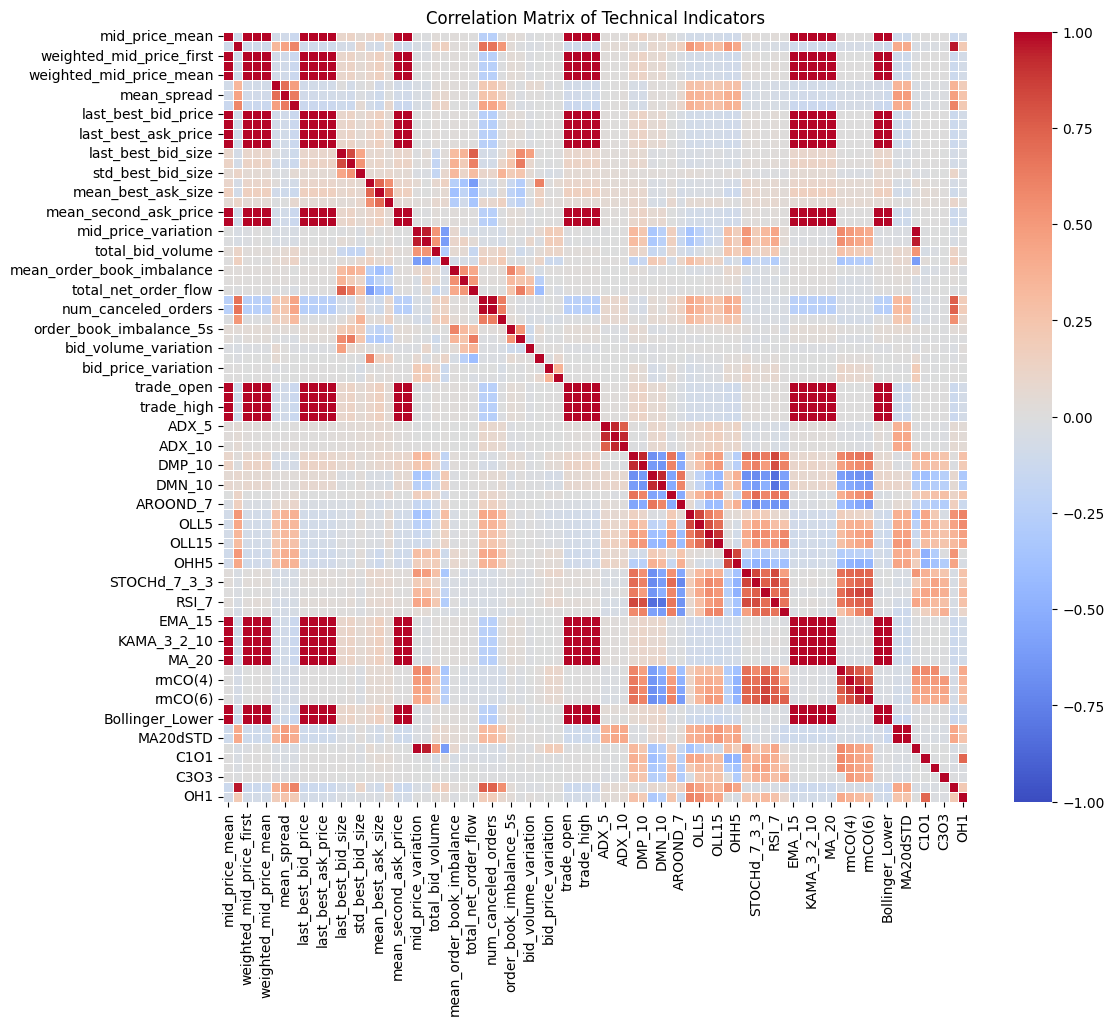

In [ ]:
import seaborn as sns

correlation_matrix = all_data.drop(columns=["mid_price_variation_class", "weighted_mid_price_variation_class", "mean_mid_price_variation_class"]).corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, linewidths=0.5)
plt.title("Correlation Matrix of Technical Indicators")
plt.show()

# Random Forest

Top 25 Most Important Features:
                         Feature  Importance
30       order_book_imbalance_5s    0.026629
17             std_best_ask_size    0.025532
33          ask_volume_variation    0.025406
22              total_bid_volume    0.025115
14             std_best_bid_size    0.025052
23              total_ask_volume    0.024626
32          bid_volume_variation    0.024383
16            mean_best_ask_size    0.024299
31                 order_flow_5s    0.024012
6                    mean_spread    0.023964
24     mean_order_book_imbalance    0.023417
13            mean_best_bid_size    0.023302
25     last_order_book_imbalance    0.022760
42                        ADX_10    0.022456
7                     std_spread    0.022423
44                        DMP_10    0.021680
45                         DMN_5    0.021527
46                        DMN_10    0.021236
57                   MACD_8_21_5    0.020851
40                         ADX_5    0.020773
43                     

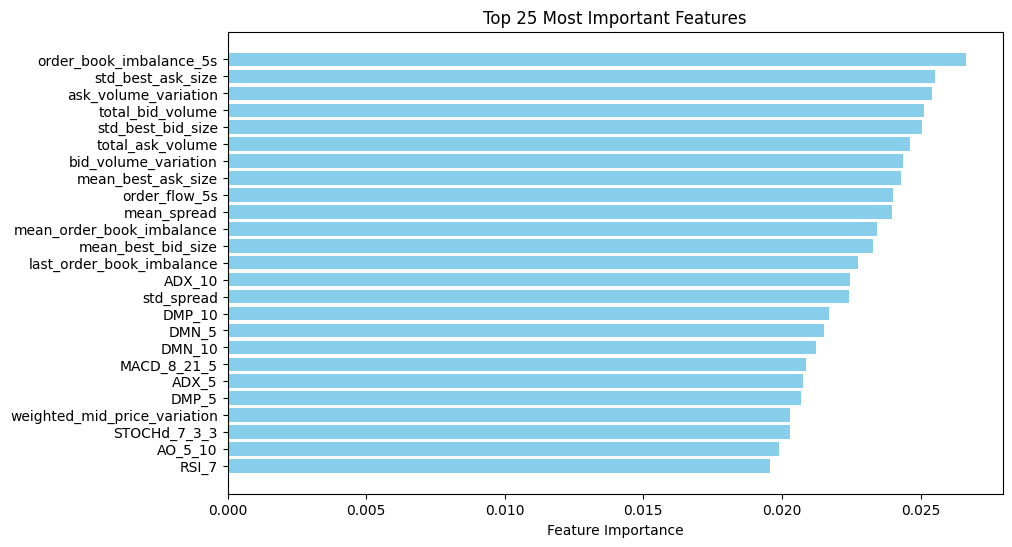

Top 25 Most Important Features:
                         Feature  Importance
30       order_book_imbalance_5s    0.027381
17             std_best_ask_size    0.025607
33          ask_volume_variation    0.025353
22              total_bid_volume    0.024925
14             std_best_bid_size    0.024915
23              total_ask_volume    0.024802
32          bid_volume_variation    0.024504
31                 order_flow_5s    0.024386
42                        ADX_10    0.023310
13            mean_best_bid_size    0.023248
16            mean_best_ask_size    0.023222
6                    mean_spread    0.023193
25     last_order_book_imbalance    0.023126
24     mean_order_book_imbalance    0.022890
7                     std_spread    0.022809
40                         ADX_5    0.021748
46                        DMN_10    0.021452
44                        DMP_10    0.021426
57                   MACD_8_21_5    0.021327
45                         DMN_5    0.021070
43                     

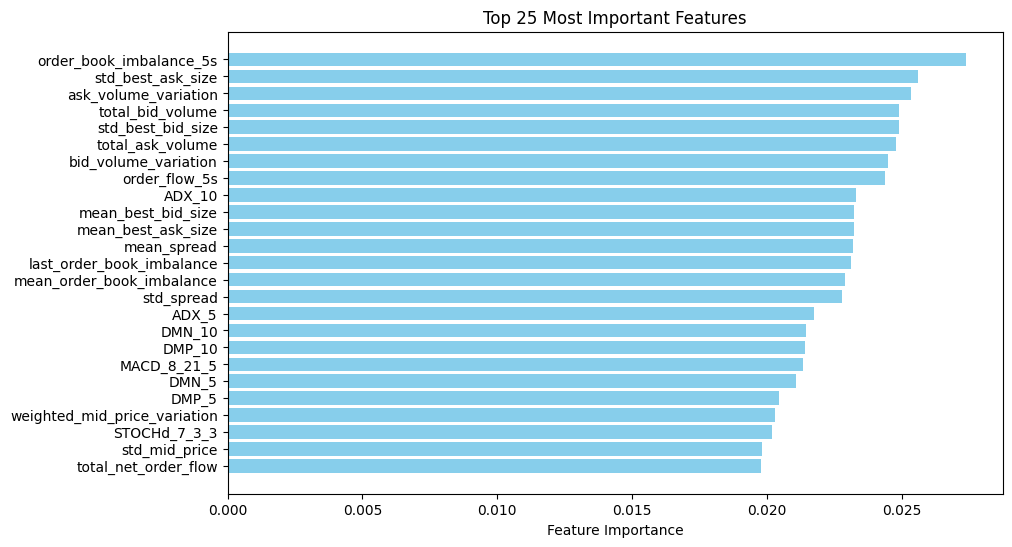

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X = all_data.drop(columns=['mid_price_variation_class', 'weighted_mid_price_variation_class', "mean_mid_price_variation_class"])  # Features
y = all_data['weighted_mid_price_variation_class']  # Target variable

params0 = {
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}
params1 = {
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1
}

params2={
    'n_estimators': 100,
    'max_depth': None,
    'min_samples_split': 10,
    'min_samples_leaf': 5
}
params3={
    'n_estimators': 50,
    'max_depth': None,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features' : 0.3
}

def analyze_feature_importance(X, y, num_features=None, **rf_params):
    """
    Analyze and visualize feature importance using a Random Forest model.

    Parameters:
        X (pd.DataFrame): DataFrame containing the features.
        y (pd.Series): Series containing the target variable.
        num_features (int): Number of top features to display and plot.
        **rf_params: Additional parameters to pass to RandomForestClassifier.

    Returns:
        importance_df (pd.DataFrame): DataFrame containing features and their importance scores.
    """
    # Initialize the Random Forest model
    rf = RandomForestRegressor(**rf_params)

    # Train the model on the entire dataset
    rf.fit(X, y)

    # Get feature importances
    feature_importances = rf.feature_importances_

    # Create a DataFrame to display feature importances
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': feature_importances
    })

    # Sort features by importance
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    if num_features is None:
        num_features = len(importance_df)

    # Display the top `num_features` most important features
    print(f"Top {num_features} Most Important Features:")
    print(importance_df.head(num_features))

    # Plot feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'][:num_features], importance_df['Importance'][:num_features], color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title(f'Top {num_features} Most Important Features')
    plt.gca().invert_yaxis() 
    plt.show()

    return importance_df

importance_df0 = analyze_feature_importance(X, y, num_features=25, **params0)
importance_df1 = analyze_feature_importance(X, y, num_features=25, **params1)
# importance_df2 = analyze_feature_importance(X, y, **params2)
# importance_df3 = analyze_feature_importance(X, y, **params3)

Top 15 Most Important Features:
     Feature  Importance
5      DMN_5    0.102260
2     ADX_10    0.099969
6     DMN_10    0.099335
4     DMP_10    0.099279
3      DMP_5    0.098599
0      ADX_5    0.098104
1      ADX_7    0.090533
12     OLL15    0.049530
14      OHH5    0.045199
13      OHH3    0.041052
11     OLL10    0.040693
9       OLL3    0.038045
10      OLL5    0.037372
7   AROONU_7    0.030098
8   AROOND_7    0.029931


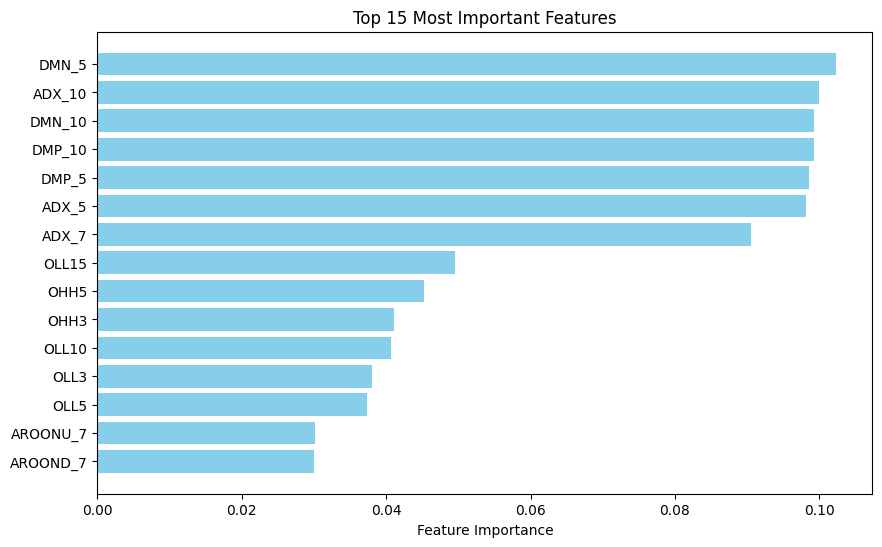

Top 5 Most Important Features:
        Feature  Importance
2   MACD_8_21_5    0.239158
3         RSI_7    0.233102
1  STOCHd_7_3_3    0.202946
4       AO_5_10    0.193291
0  STOCHk_7_3_3    0.131503


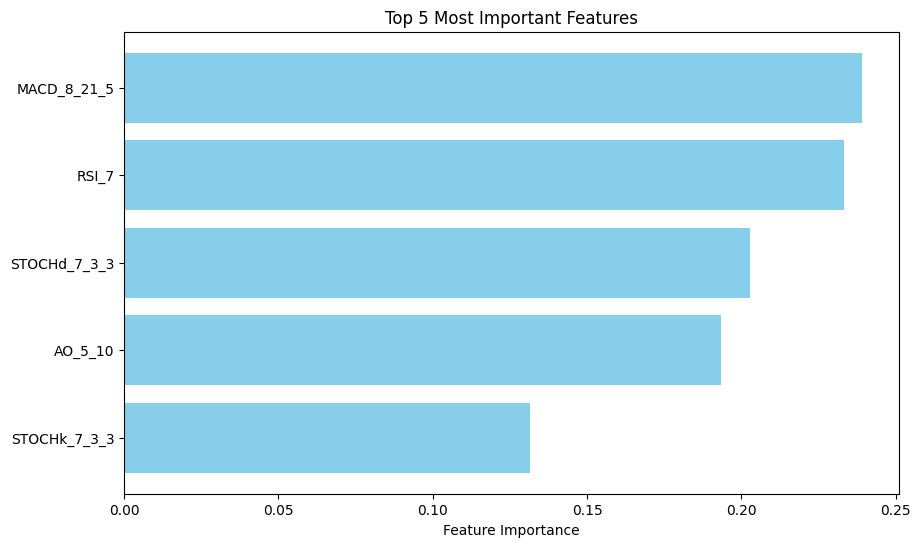

Top 9 Most Important Features:
       Feature  Importance
4        MA_20    0.158632
2  KAMA_3_2_10    0.130060
0       EMA_15    0.123006
1       HMA_10    0.108197
3        MA_10    0.106259
8      rmCO(6)    0.101621
7      rmCO(5)    0.092794
5      rmCO(3)    0.089775
6      rmCO(4)    0.089658


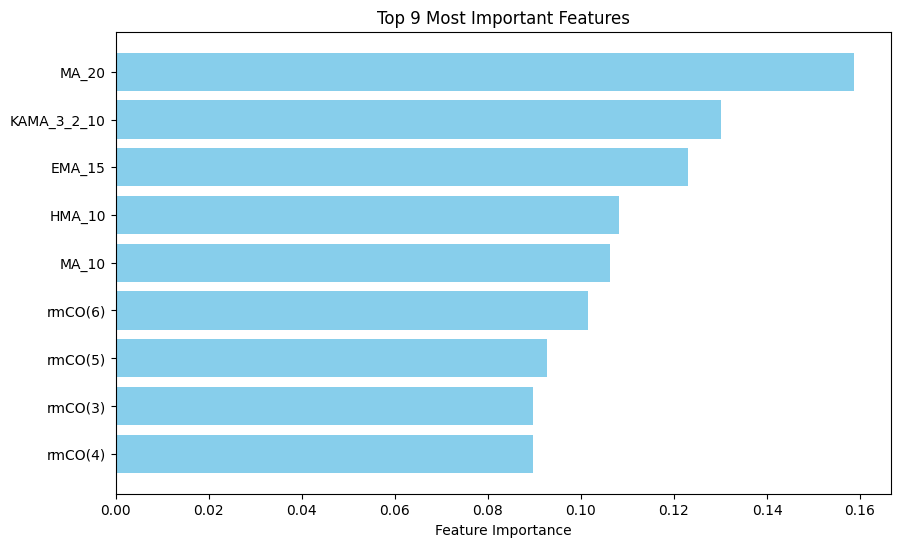

Top 4 Most Important Features:
           Feature  Importance
1  Bollinger_Lower    0.265915
0  Bollinger_Upper    0.264654
3         MA20dSTD    0.235873
2        U_minus_L    0.233558


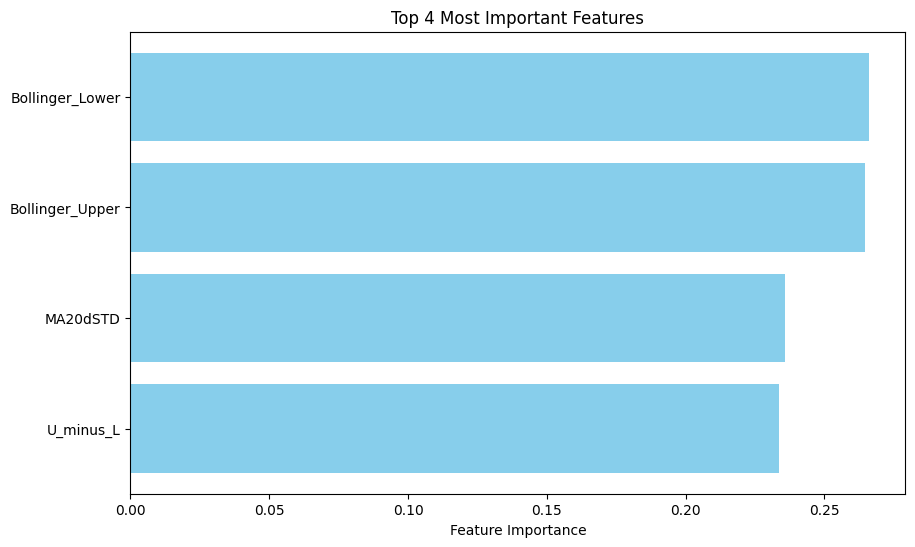

Top 6 Most Important Features:
  Feature  Importance
3    C3O3    0.203983
2    C2O2    0.200526
1    C1O1    0.179836
4   range    0.154029
0      CO    0.147001
5     OH1    0.114624


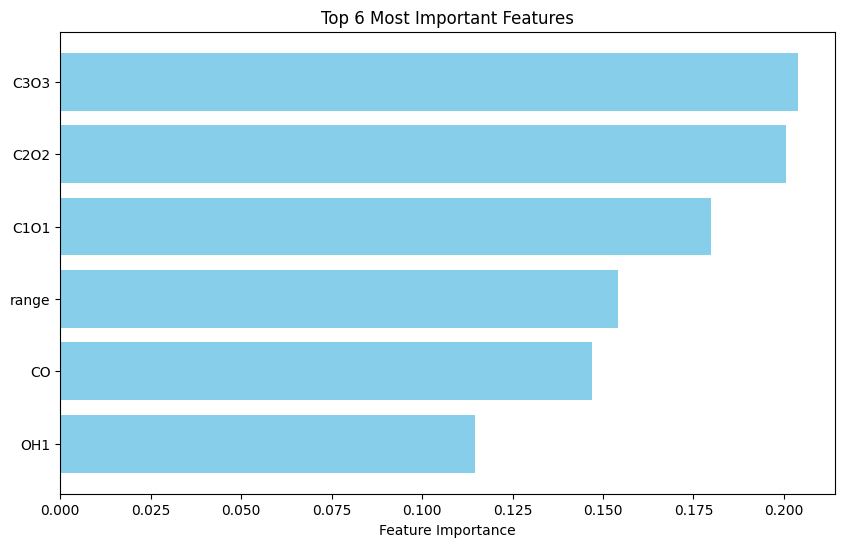

KeyError: "['mid_price_high', 'mid_price_low', 'mid_price_last', 'mid_price_first', 'weighted_mid_price_meanweighted_mid_price_last'] not in index"

In [50]:
# Technical indicators
trend_indicators = ['ADX_5', 'ADX_7', 'ADX_10', 'DMP_5', 'DMP_10', 'DMN_5', 'DMN_10', 'AROONU_7', 'AROOND_7', 'OLL3', 'OLL5', 'OLL10', 'OLL15', 'OHH3', 'OHH5']
oscillators =[ 'STOCHk_7_3_3', 'STOCHd_7_3_3', 'MACD_8_21_5', 'RSI_7', 'AO_5_10']
moving_averages = ['EMA_15', 'HMA_10', 'KAMA_3_2_10', 'MA_10', 'MA_20', 'rmCO(3)', 'rmCO(4)', 'rmCO(5)', 'rmCO(6)']
volatility_indicators = ['Bollinger_Upper', 'Bollinger_Lower', 'U_minus_L', 'MA20dSTD']
other_indicators = ['CO', 'C1O1', 'C2O2', 'C3O3', 'range', 'OH1']

# LOB specific indicators
mid_price_indicators = ['mid_price_mean', 'std_mid_price', 'weighted_mid_price_first', 'weighted_mid_price_mean'
       'weighted_mid_price_last', 'mid_price_variation', 'weighted_mid_price_variation']
bid_ask_prices_indicators = ['last_best_bid_price',
       'mean_best_bid_price', 'last_best_ask_price', 'mean_best_ask_price', 'bid_price_variation', 'ask_price_variation', 'last_spread',
       'mean_spread', 'std_spread', 'mean_second_ask_price', 'mean_second_bid_price']
volume_indicators = ['last_best_bid_size', 'mean_best_bid_size', 'std_best_bid_size',
       'last_best_ask_size', 'mean_best_ask_size', 'std_best_ask_size','bid_volume_variation', 'ask_volume_variation','total_bid_volume',
       'total_ask_volume',]
orders_indicators = ['total_net_order_flow', 'num_added_orders', 'mean_order_book_imbalance',
       'last_order_book_imbalance', 'order_book_imbalance_5s',
       'order_flow_5s', 
       'num_canceled_orders', 'num_traded_orders', ]

ohlc_indicators = ['trade_open', 'trade_close', 'trade_high', 'trade_low']

importance_df_trend0 = analyze_feature_importance(X[trend_indicators], y, **params0)
importance_df_trend1 = analyze_feature_importance(X[oscillators], y, **params1)
importance_df_trend2 = analyze_feature_importance(X[moving_averages], y, **params2)
importance_df_trend3 = analyze_feature_importance(X[volatility_indicators], y, **params3)
importance_df_trend4 = analyze_feature_importance(X[other_indicators], y, **params0)


Top 7 Most Important Features:
                        Feature  Importance
1                 std_mid_price    0.257751
6  weighted_mid_price_variation    0.237185
2      weighted_mid_price_first    0.113084
4       weighted_mid_price_last    0.112534
3       weighted_mid_price_mean    0.105631
0                mid_price_mean    0.105556
5           mid_price_variation    0.068258


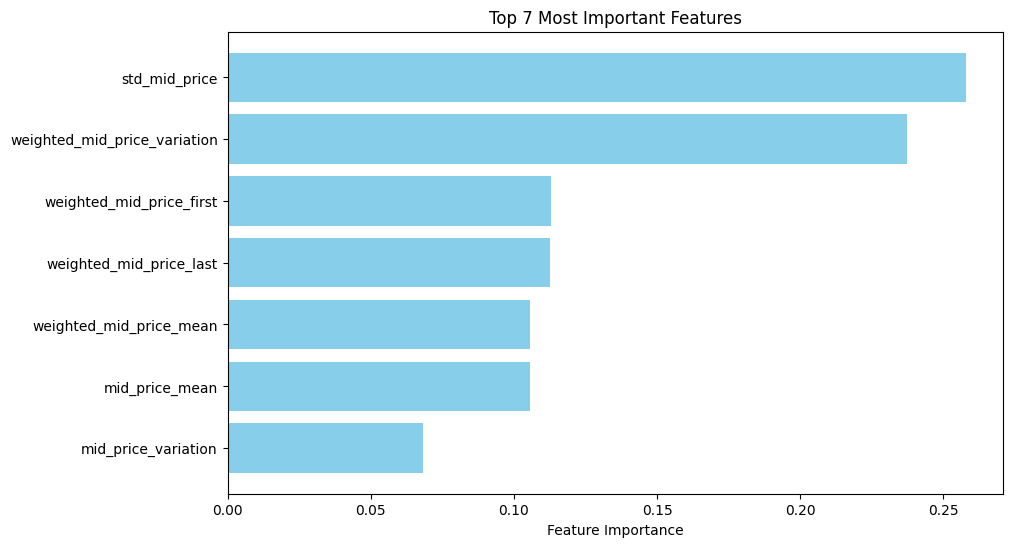

Top 11 Most Important Features:
                  Feature  Importance
8              std_spread    0.276522
7             mean_spread    0.266408
10  mean_second_bid_price    0.080474
9   mean_second_ask_price    0.079186
1     mean_best_bid_price    0.079105
3     mean_best_ask_price    0.078020
0     last_best_bid_price    0.057813
2     last_best_ask_price    0.054958
6             last_spread    0.025680
5     ask_price_variation    0.000996
4     bid_price_variation    0.000837


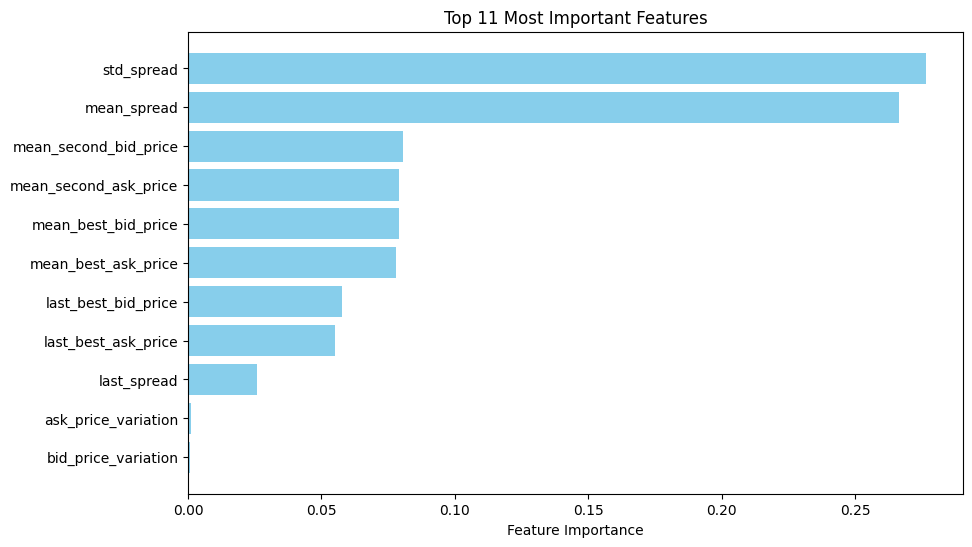

Top 10 Most Important Features:
                Feature  Importance
8      total_bid_volume    0.106430
4    mean_best_ask_size    0.105734
5     std_best_ask_size    0.104962
1    mean_best_bid_size    0.104821
2     std_best_bid_size    0.104708
9      total_ask_volume    0.103180
6  bid_volume_variation    0.098484
7  ask_volume_variation    0.097539
0    last_best_bid_size    0.087650
3    last_best_ask_size    0.086493


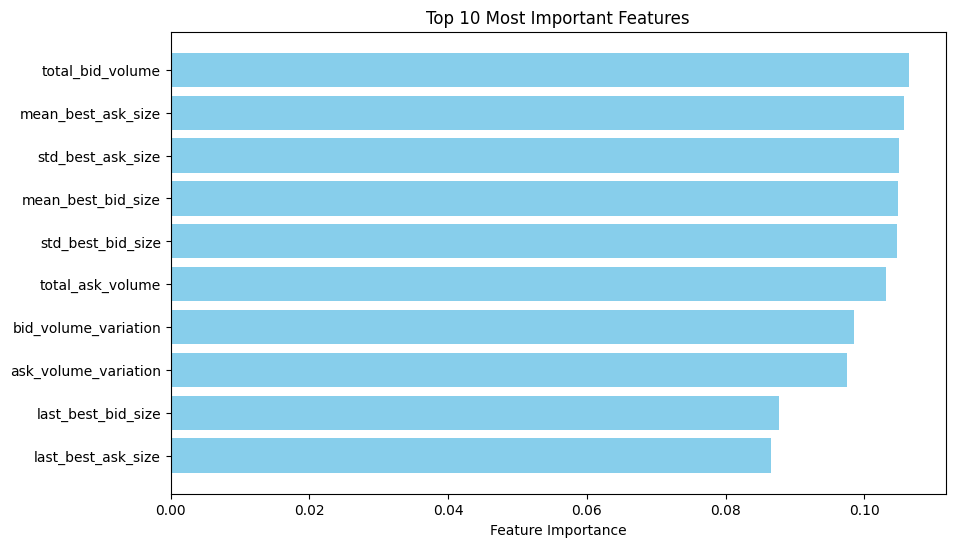

Top 8 Most Important Features:
                     Feature  Importance
2  mean_order_book_imbalance    0.154555
4    order_book_imbalance_5s    0.151718
5              order_flow_5s    0.147466
3  last_order_book_imbalance    0.141369
0       total_net_order_flow    0.128125
1           num_added_orders    0.100487
6        num_canceled_orders    0.099402
7          num_traded_orders    0.076878


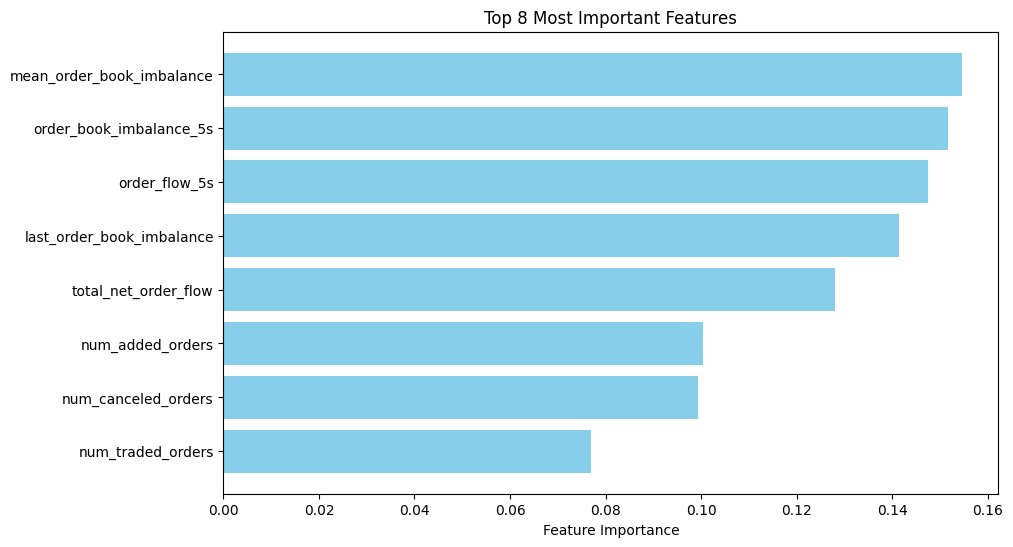

In [52]:
importance_df_trend5 = analyze_feature_importance(X[mid_price_indicators], y, **params1)
importance_df_trend6 = analyze_feature_importance(X[bid_ask_prices_indicators], y, **params2)
importance_df_trend7 = analyze_feature_importance(X[volume_indicators], y, **params3)
importance_df_trend8 = analyze_feature_importance(X[orders_indicators], y, **params0)

# Mutual Info Scores

Top 20 Features by Mutual Information:
                      Feature  Mutual_Information
26       total_net_order_flow            0.011076
67                    rmCO(5)            0.007626
20        mid_price_variation            0.007324
4     weighted_mid_price_mean            0.007124
25  last_order_book_imbalance            0.006131
2    weighted_mid_price_first            0.006035
8         last_best_bid_price            0.005517
78                        OH1            0.004665
24  mean_order_book_imbalance            0.004627
28        num_canceled_orders            0.004462
12         last_best_bid_size            0.004450
50                       OLL5            0.004274
3     weighted_mid_price_last            0.004171
60                     EMA_15            0.004073
64                      MA_20            0.003939
22           total_bid_volume            0.003681
42                     ADX_10            0.003489
56               STOCHd_7_3_3            0.002525
39         

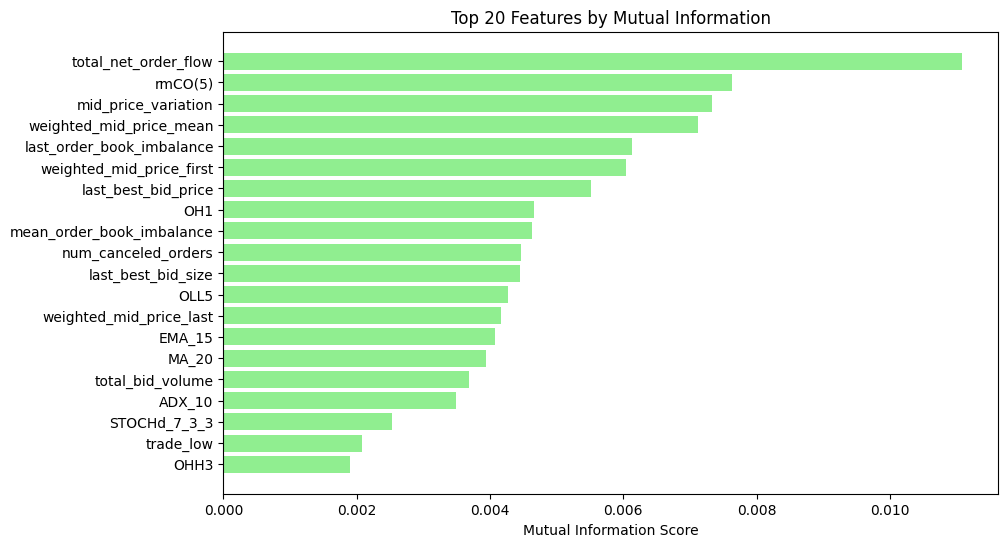

In [ ]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

X = all_data.drop(columns=['mid_price_variation_class', 'weighted_mid_price_variation_class', "mean_mid_price_variation_class"])  # Features
y = all_data['weighted_mid_price_variation_class']  # Target variable

def analyze_mutual_information(X, y, num_features=None, discrete_features='auto', random_state=None):
    """
    Analyze and visualize feature importance using Mutual Information.

    Parameters:
        X (pd.DataFrame): DataFrame containing the features.
        y (pd.Series): Series containing the target variable.
        num_features (int): Number of top features to display and plot.
        discrete_features (str or array-like): Whether to treat features as discrete. 
            'auto' infers it from the data.
        random_state (int): Random seed for reproducibility.

    Returns:
        mi_df (pd.DataFrame): DataFrame containing features and their mutual information scores.
    """
    # Calculate Mutual Information scores
    if y.dtype == 'object' or y.dtype.name == 'category':
        mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=random_state)
    else:
        mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=random_state)

    # Create a DataFrame to display MI scores
    mi_df = pd.DataFrame({
        'Feature': X.columns,
        'Mutual_Information': mi_scores
    })

    # Sort features by MI scores
    mi_df = mi_df.sort_values(by='Mutual_Information', ascending=False)

    if num_features is None:
        num_features = len(mi_df)

    # Display the top `num_features` features with the highest MI scores
    print(f"Top {num_features} Features by Mutual Information:")
    print(mi_df.head(num_features))

    # Plot MI scores
    plt.figure(figsize=(10, 6))
    plt.barh(mi_df['Feature'][:num_features], mi_df['Mutual_Information'][:num_features], color='lightgreen')
    plt.xlabel('Mutual Information Score')
    plt.title(f'Top {num_features} Features by Mutual Information')
    plt.gca().invert_yaxis() 
    plt.show()

    return mi_df

# Example usage
mi_df = analyze_mutual_information(X, y, num_features=20)

# SHAP Importance Scores

100%|===================| 30473/30595 [01:19<00:00]        

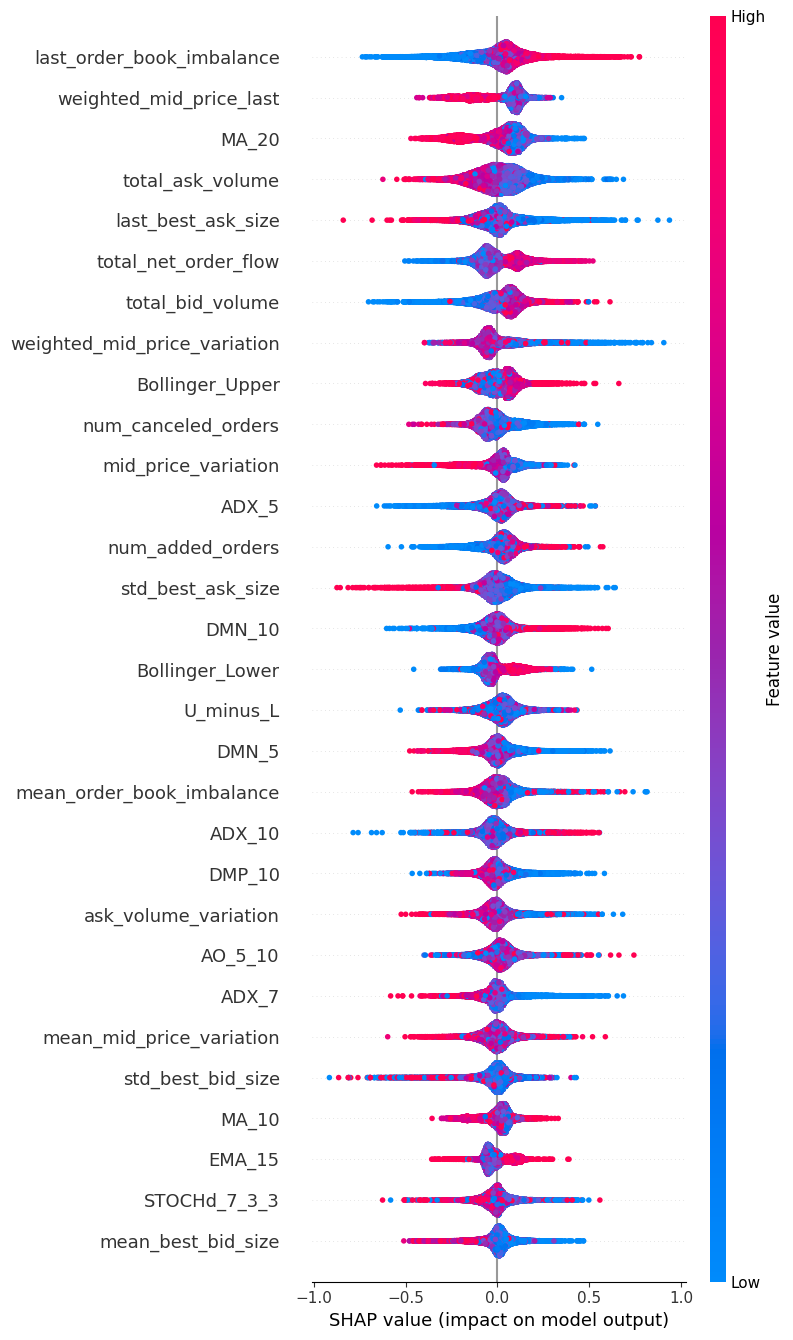

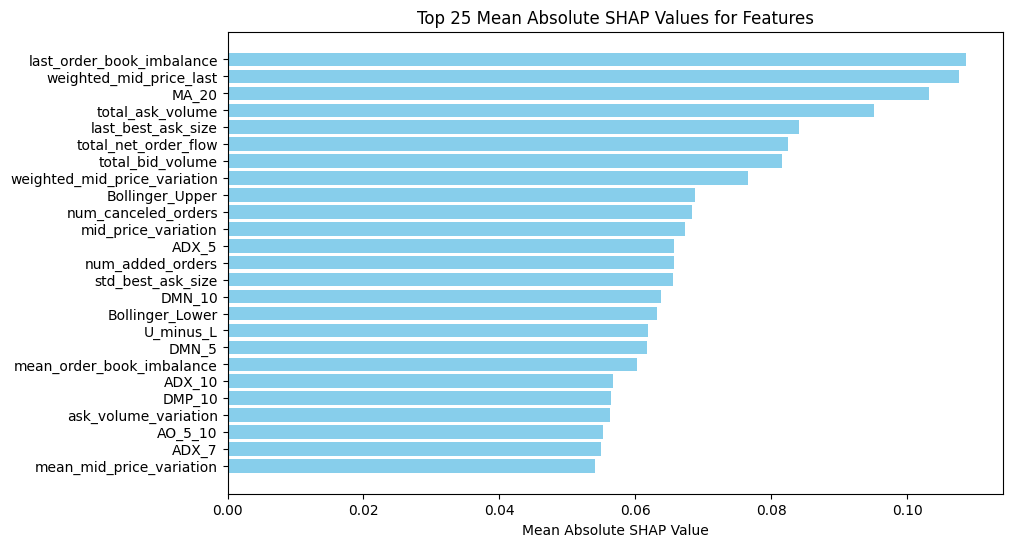

                         Feature  Mean Absolute SHAP Value
26     last_order_book_imbalance                  0.108628
3        weighted_mid_price_last                  0.107653
65                         MA_20                  0.103156
24              total_ask_volume                  0.095131
15            last_best_ask_size                  0.084050
27          total_net_order_flow                  0.082512
23              total_bid_volume                  0.081598
22  weighted_mid_price_variation                  0.076596
70               Bollinger_Upper                  0.068749
29           num_canceled_orders                  0.068299
20           mid_price_variation                  0.067343
41                         ADX_5                  0.065734
28              num_added_orders                  0.065712
17             std_best_ask_size                  0.065536
47                        DMN_10                  0.063761
71               Bollinger_Lower                  0.0631

In [10]:
import shap
import xgboost as xgb

X = all_data.drop(columns=['mid_price_variation_class', 'weighted_mid_price_variation_class', "mean_mid_price_variation_class"])  # Features
y = all_data['mean_mid_price_variation_class']  # Target variable

# Train XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X, y)

# SHAP Analysis
explainer = shap.Explainer(xgb_model, X)
shap_values = explainer(X)

# Show more values in the SHAP summary plot
shap.summary_plot(shap_values, X, max_display=30)  # Adjust max_display to show more features

# Calculate mean absolute SHAP values
mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
shap_df = pd.DataFrame({
    'Feature': X.columns,
    'Mean Absolute SHAP Value': mean_abs_shap_values
}).sort_values(by='Mean Absolute SHAP Value', ascending=False)

# Plot mean absolute SHAP values for the top 25 features
top_features = shap_df.head(25)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Mean Absolute SHAP Value'], color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.title('Top 25 Mean Absolute SHAP Values for Features')
plt.gca().invert_yaxis()
plt.show()

print(top_features)

# PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_feature_selection(df, n_components=None, variance_threshold=0.95, num_features_to_keep=20):
    """
    Perform PCA-based feature selection and visualize the importance of the selected features.

    Parameters:
    - df: pandas DataFrame, the input dataset.
    - n_components: int or None, the number of principal components to keep. If None, it will be determined by the variance_threshold.
    - variance_threshold: float, the cumulative explained variance threshold to use if n_components is None.
    - num_features_to_keep: int, the number of top features to select.

    Returns:
    - features_to_keep: list, the names of the selected features.
    - sum_loadings: numpy array, the importance scores of the selected features.
    - selected_components_df: pandas DataFrame, the PCA components for the selected features.
    """
    # Step 1: Extract feature names and data
    features = df.columns.tolist() 
    X = df.values 

    # Step 2: Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 3: Apply PCA
    if n_components is None:
        # Compute all components to analyze explained variance
        pca = PCA()
        X_pca = pca.fit_transform(X_scaled)
        
        # Calculate cumulative explained variance
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        
        # Determine the number of components to retain based on the variance threshold
        n_components = np.argmax(cumulative_variance >= variance_threshold) + 1
        print(f"Selected {n_components} components to explain {variance_threshold * 100}% of the variance.")
        
        # Re-fit PCA with the selected number of components
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
    else:
        # Use the specified number of components
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)

    # Step 4: Get PCA components (loadings)
    components = pca.components_  # Each row is a principal component, each column is a feature
    components_df = pd.DataFrame(components, columns=features, index=[f'PC{i+1}' for i in range(len(components))])

    # Step 5: Calculate absolute factor loadings and sum them
    absolute_loadings = np.abs(components)  # Absolute values of loadings
    sum_loadings = np.sum(absolute_loadings, axis=0)  # Sum of loadings for each feature

    # Step 6: Sort features by importance
    sorted_indices = np.argsort(sum_loadings)[::-1]  # Indices of features sorted by importance

    # Step 7: Select top features
    features_to_keep = [features[i] for i in sorted_indices[:num_features_to_keep]]  # Top features

    # Step 8: Display results
    print("Top Features to Keep:", features_to_keep)
    print("\nImportance of Selected Features:")
    for feature in features_to_keep:
        index = features.index(feature)
        print(f"{feature}: Importance = {sum_loadings[index]:.4f}")

    # Step 9: Display PCA components for selected features
    selected_components_df = components_df[features_to_keep]
    print("\nPCA Components for Selected Features:")
    print(selected_components_df)

    # Step 10: Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.bar(range(num_features_to_keep), sum_loadings[sorted_indices[:num_features_to_keep]], align='center', color='skyblue')
    plt.xticks(range(num_features_to_keep), features_to_keep, rotation=45, ha='right')
    plt.xlabel('Features')
    plt.ylabel('Importance (Sum of Absolute Loadings)')
    plt.title('Top Features by Importance')
    plt.tight_layout()
    plt.show()

    return features_to_keep, sum_loadings, selected_components_df

Selected 19 components to explain 95.0% of the variance.
Top Features to Keep: ['trade_bid_size', 'trade_ask_size', 'net_add_bid_size', 'net_add_ask_size', 'volatilities', 'C3O3', 'DMP_10', 'AROONU_7', 'DMN_10', 'AROOND_7', 'C2O2', 'STOCHk_14_3_3', 'OHH3', 'OH1', 'DMP_5', 'MA20dSTD', 'U_minus_L', 'STOCHd_14_3_3', 'DMN_5', 'AO_5_10']

Importance of Selected Features:
trade_bid_size: Importance = 3.3957
trade_ask_size: Importance = 3.3535
net_add_bid_size: Importance = 3.2003
net_add_ask_size: Importance = 3.1248
volatilities: Importance = 2.6962
C3O3: Importance = 2.6609
DMP_10: Importance = 2.6437
AROONU_7: Importance = 2.5576
DMN_10: Importance = 2.4994
AROOND_7: Importance = 2.4751
C2O2: Importance = 2.4361
STOCHk_14_3_3: Importance = 2.2765
OHH3: Importance = 2.2248
OH1: Importance = 2.1968
DMP_5: Importance = 2.1927
MA20dSTD: Importance = 2.1412
U_minus_L: Importance = 2.1412
STOCHd_14_3_3: Importance = 2.1400
DMN_5: Importance = 2.1141
AO_5_10: Importance = 2.0460

PCA Components 

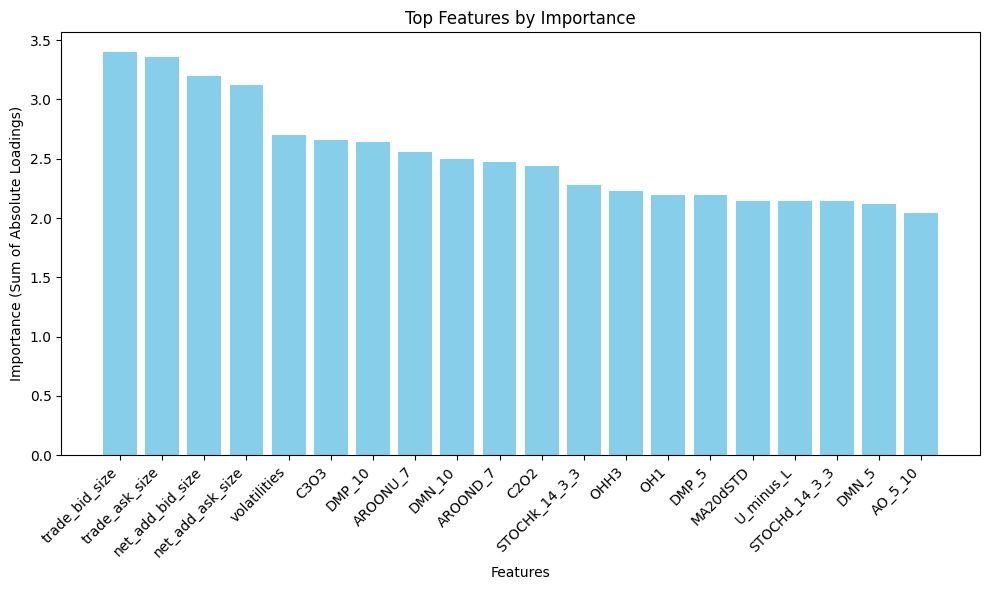

In [ ]:
# Change all_data to select feature categories
features_to_keep, sum_loadings, selected_components_df = pca_feature_selection(
    all_data,  num_features_to_keep=20
)

Selected 8 components to explain 95.0% of the variance.
Top Features to Keep: ['AROOND_7', 'AROONU_7', 'OLL3', 'OLL15']

Importance of Selected Features:
AROOND_7: Importance = 2.2631
AROONU_7: Importance = 2.2136
OLL3: Importance = 2.0699
OLL15: Importance = 1.9600

PCA Components for Selected Features:
     AROOND_7  AROONU_7      OLL3     OLL15
PC1 -0.288774  0.326452  0.167489  0.330938
PC2  0.165757 -0.016420  0.310279  0.222670
PC3 -0.193065  0.011673 -0.347750 -0.166762
PC4  0.006756  0.164239 -0.250614 -0.102069
PC5  0.371207  0.277635  0.144793 -0.247136
PC6  0.618355 -0.387588  0.201022 -0.093216
PC7  0.106781  0.715818  0.193959 -0.313455
PC8  0.512386  0.313742 -0.453999  0.483729


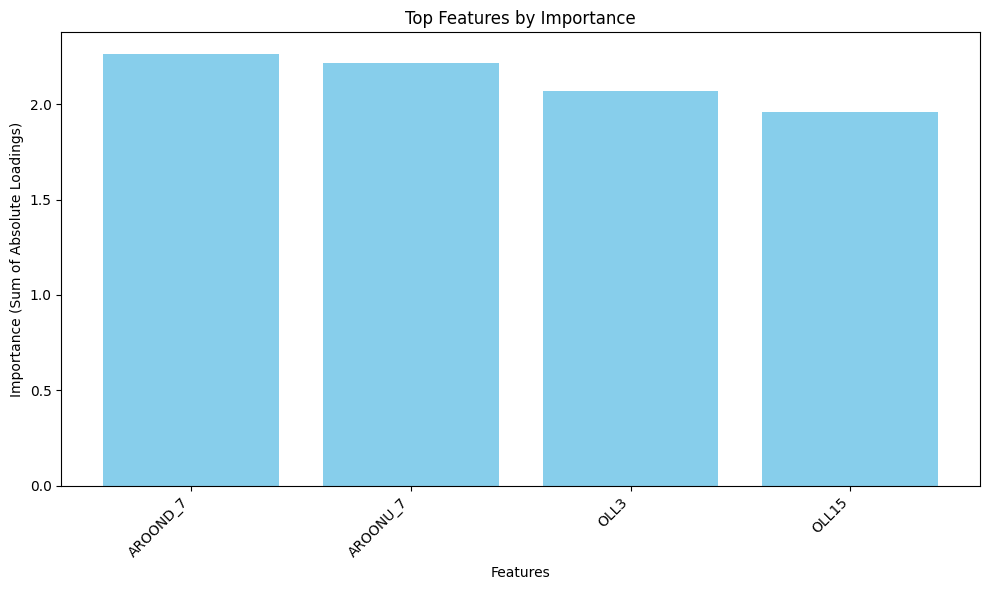

In [ ]:
# Change all_data to select feature categories
features_to_keep, sum_loadings, selected_components_df = pca_feature_selection(
    all_data[trend_indicators],  num_features_to_keep=4
)